In [2]:
pip install numpy

     ---------------------------------------- 12.9/12.9 MB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install matplotlib

     ---------------------------------------- 8.1/8.1 MB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 73.7/73.7 kB 2.0 MB/s eta 0:00:00
     -------------------------------------- 221.2/221.2 kB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 7.0/7.0 MB 2.7 MB/s eta 0:00:00
     -------------------------------------- 111.1/111.1 kB 6.3 MB/s eta 0:00:00
     ---------------------------------------- 2.3/2.3 MB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


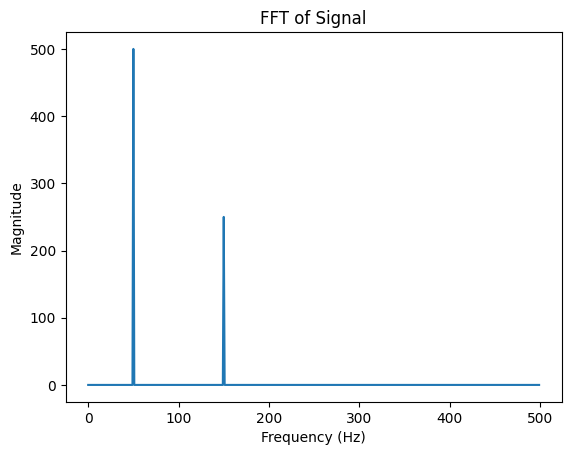

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Create a sample signal (sum of two sine waves)
Fs = 1000   # Sampling frequency
T = 1/Fs
t = np.arange(0,1,T)
f1, f2 = 50, 150  # Frequencies

signal = np.sin(2*np.pi*f1*t) + 0.5*np.sin(2*np.pi*f2*t)

# FFT
fft_vals = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(len(fft_vals), T)

# Plot
plt.plot(fft_freqs[:len(fft_freqs)//2], np.abs(fft_vals)[:len(fft_vals)//2])
plt.title("FFT of Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()


In [7]:
import numpy as np

# Test input sequence (your hardware input samples)
N = 8
x = [1,2,3,4,5,6,7,8]  # or any test vector

# Compute FFT using NumPy
fft_ref = np.fft.fft(x)

print("Reference FFT (Python):")
for val in fft_ref:
    print(val)


Reference FFT (Python):
(36+0j)
(-4+9.65685424949238j)
(-4+4j)
(-4+1.6568542494923806j)
(-4+0j)
(-4-1.6568542494923806j)
(-4-4j)
(-4-9.65685424949238j)


In [8]:
import numpy as np

# -------- Test vector (64 samples) ----------
# Example 1: impulse (easy sanity check)
x = np.zeros(64, dtype=np.complex64)
x[0] = 1.0 + 0.0j   # impulse at n=0

# Example 2: ramp (more complex)
# x = np.array([complex(k,0) for k in range(64)], dtype=np.complex64)

# -------- Compute FFT --------
fft_out = np.fft.fft(x)

# -------- Fixed-point conversion (Q1.15 for each part) --------
def float_to_fixed(val, bits=16, frac=15):
    return int(np.round(val * (1<<frac))) & ((1<<bits)-1)

def complex_to_hw(val):
    real = float_to_fixed(val.real)
    imag = float_to_fixed(val.imag)
    return (imag<<16) | (real & 0xFFFF)

# Pack values for feeding hardware
hw_inputs = [complex_to_hw(v) for v in x]
hw_outputs = [complex_to_hw(v) for v in fft_out]

print("Hardware input words:", [hex(v) for v in hw_inputs])
print("Expected FFT outputs:", [hex(v) for v in hw_outputs])


Hardware input words: ['0x8000', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0']
Expected FFT outputs: ['0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x8000', '0x

In [10]:
import numpy as np

# Path
path = r"C:\Users\nages\verilog_projects\FFT64Bit1Ver"

# -------- Generate input.hex --------
N = 64
n = np.arange(N)
x = np.exp(2j * np.pi * n / N)   # test signal

def float_to_fixed(val, bits=16):
    val_int = int(np.round(val * (2**(bits-1)-1)))
    if val_int < 0:
        val_int = (1 << bits) + val_int
    return val_int & ((1<<bits)-1)

with open(path + r"\input.hex", "w") as f:
    for v in x:
        re = float_to_fixed(v.real)
        im = float_to_fixed(v.imag)
        word = (im << 16) | re
        f.write(f"{word:08X}\n")


In [11]:
output_vals = []
with open(path + r"\output.hex", "r") as f:
    for line in f:
        word = int(line.strip(), 16)
        re = np.int16(word & 0xFFFF)
        im = np.int16(word >> 16)
        output_vals.append(re + 1j*im)
output_vals = np.array(output_vals)

# Reference FFT
ref_fft = np.fft.fft(x)

# Difference
print("Max abs difference:", np.max(np.abs(output_vals - ref_fft)))


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\nages\\verilog_projects\\FFT64Bit1Ver\\output.hex'